In [51]:
import re
import json
import statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [2]:
FILEPATH_BASE = 'QNLI/QNLI-Stress Test/'

FILEPATH_TRAIN = 'QNLI-Stress Test_train.json'
FILEPATH_TEST = 'QNLI-Stress Test_test.json'
FILEPATH_DEV = 'QNLI-Stress Test_dev.json'

with open(FILEPATH_BASE + FILEPATH_TRAIN, 'r') as file:
    train = json.load(file)

with open(FILEPATH_BASE + FILEPATH_DEV, 'r') as file:
    dev = json.load(file)

with open(FILEPATH_BASE + FILEPATH_TEST, 'r') as file:
    test = json.load(file)


print(len(train))
print(len(dev))
print(len(test))

6475
970
1691


In [3]:
train[0]

{'statement1': "'' Someone just came in and shot my daughter and husband , '' Flores ' wife frantically told 911 .",
 'statement2': 'Raul Flores , daughter , 9 , shot dead ; wire calls 911',
 'options': ' Entailment or neutral?',
 'answer': 'neutral',
 'type': 'Type_7',
 'statement1_sci_10E': "'' Someone just came in and shot my daughter and husband , '' Flores ' wife frantically told 9.1100000000E+02 .",
 'statement1_char': "'' Someone just came in and shot my daughter and husband , '' Flores ' wife frantically told 9 1 1 .",
 'statement1_sci_10E_char': "'' Someone just came in and shot my daughter and husband , '' Flores ' wife frantically told 9 . 1 1 0 0 0 0 0 0 0 0 E + 0 2 .",
 'statement2_sci_10E': 'Raul Flores , daughter , 9.0000000000E+00 , shot dead ; wire calls 9.0000000000E+0011',
 'statement2_char': 'Raul Flores , daughter , 9 , shot dead ; wire calls 9 1 1',
 'statement2_sci_10E_char': 'Raul Flores , daughter , 9 . 0 0 0 0 0 0 0 0 0 0 E + 0 0 , shot dead ; wire calls 9 . 0

# sanity check

In [4]:
def have_same_structure(*datasets):
    if not datasets:
        return True  

    reference_keys = set(datasets[0][0].keys())

    for dataset in datasets:
        for record in dataset: 
            if (set(record.keys()) != reference_keys): 
                return False
    return True
        

In [5]:
have_same_structure()

True

In [6]:
have_same_structure(train, dev, test)

True

In [7]:
list(train[0].keys())

['statement1',
 'statement2',
 'options',
 'answer',
 'type',
 'statement1_sci_10E',
 'statement1_char',
 'statement1_sci_10E_char',
 'statement2_sci_10E',
 'statement2_char',
 'statement2_sci_10E_char',
 'statement1_mask',
 'statement2_mask',
 'EQUATE']

Okay so train/dev/test are all lists of dictionaries of the same keys.

# understand the fields

In [8]:
def get_unique_values(dicts, target_key):
    if not dicts:
        return True  # An empty list is considered to have the same structure

    freq_counts = Counter(item[target_key] for item in dicts)


    return freq_counts

In [9]:
print(get_unique_values(train, 'EQUATE'))
print(get_unique_values(dev, 'EQUATE'))
print(get_unique_values(test, 'EQUATE'))

Counter({'StressTest': 4619, 'NewsNLI': 968, 'AWPNLI': 722, 'RTE_Quant': 166})
Counter({'StressTest': 970})
Counter({'StressTest': 1691})


In [10]:
print(get_unique_values(train, 'options'))
print(get_unique_values(dev, 'options'))
print(get_unique_values(test, 'options'))

Counter({' Entailment or contradiction or neutral?': 4619, ' Entailment or neutral?': 1134, ' Entailment or contradiction?': 722})
Counter({' Entailment or contradiction or neutral?': 970})
Counter({' Entailment or contradiction or neutral?': 1691})


In [11]:
print(get_unique_values(train, 'answer'))
print(get_unique_values(dev, 'answer'))
print(get_unique_values(test, 'answer'))

Counter({'Entailment': 2461, 'neutral': 2112, 'contradiction': 1902})
Counter({'Entailment': 324, 'neutral': 323, 'contradiction': 323})
Counter({'contradiction': 564, 'neutral': 564, 'Entailment': 563})


In [12]:
print(get_unique_values(train, 'type'))
print(get_unique_values(dev, 'type'))
print(get_unique_values(test, 'type'))

Counter({'Type_7': 6475})
Counter({'Type_7': 970})
Counter({'Type_7': 1691})


Findings: 
* Only in the `train` set does the data come from different EQUATE subsets. `dev` and `test` all come from Stress dataset. 
* In `train` set, some of the questions can potentiallly be any of the 3 labels, some questions can only be one of the 2 labels. In `dev` and `test` all questions can have either of the 3 labels.

We don't need these 3 fields: `type`,`statement1_mask`, `statement2_mask`.   
* Because `type` are all the same (probably referring to the task number in NumGlue since QNLI is task 7 in NumGlue dataset).
* `statement1_mask`, `statement2_mask` are not relevant to our task. 

Relevant fields are: 
* (`statement1`, `statement2`) for original notation
 `options`,
* (`statement1_sci_10E`, `statement2_sci_10E`) for scientific notation
* (`statement1_char`, `statement2_char`) for character notation
* (`statement1_sci_10E_char`, `statement2_sci_10E_char`) for character-scientific notation
* `options` indicate the range of possible ansers (only have diff value in `train` set)
* `answer` to indicate weather its "Entailment", "Contradiction", or "Neutral"
* `EQUATE` to indicate which subset of EQUATE it comes from (only have diff value in `train` set)

# different sources of training set

In [13]:
df = pd.DataFrame(train)

cross_tab = pd.crosstab(index=df['options'], columns=df['EQUATE'])

cross_tab

EQUATE,AWPNLI,NewsNLI,RTE_Quant,StressTest
options,,,,
Entailment or contradiction or neutral?,0,0,0,4619
Entailment or contradiction?,722,0,0,0
Entailment or neutral?,0,968,166,0


# is answers evenly distributed? 

In [14]:
def get_answer_percentage(dicts): 
    answer_counter = get_unique_values(dicts, 'answer')
    
    answer_freq = {key: round(value / len(dicts), 4) for key, value in answer_counter.items()}
    
    return answer_freq

In [15]:
get_answer_percentage(train) # would it differ per source EQUATE? 

{'neutral': 0.3262, 'Entailment': 0.3801, 'contradiction': 0.2937}

In [16]:
get_answer_percentage(dev)

{'neutral': 0.333, 'Entailment': 0.334, 'contradiction': 0.333}

In [17]:
get_answer_percentage(test)

{'contradiction': 0.3335, 'Entailment': 0.3329, 'neutral': 0.3335}

3 answers are roughly evenly distributed in all 3 datasets. 

## subsets of train

In [18]:
def get_subset_by_equate_field(dataset, value): 
    return [record for record in dataset if record["EQUATE"] == value]

train_awpnli = get_subset_by_equate_field(train, "AWPNLI")
train_newsnli = get_subset_by_equate_field(train, "NewsNLI")
train_rte_quant = get_subset_by_equate_field(train, "RTE_Quant")
train_stress = get_subset_by_equate_field(train, "StressTest")

In [19]:
get_answer_percentage(train_awpnli)

{'contradiction': 0.5, 'Entailment': 0.5}

In [20]:
get_answer_percentage(train_newsnli)

{'neutral': 0.4928, 'Entailment': 0.5072}

In [21]:
get_answer_percentage(train_rte_quant)

{'Entailment': 0.4217, 'neutral': 0.5783}

In [22]:
get_answer_percentage(train_stress)

{'Entailment': 0.3332, 'contradiction': 0.3336, 'neutral': 0.3332}

As the [previous section](#different-sources-of-training-set) shows, records in `train` have different sources, there might be only two options for records coming from certain subset of EQUATE. 3 different answers are evenly distributed among the data that come from STRESS subset. 

# A look at numeral data

In [23]:
train[0]['statement1']

"'' Someone just came in and shot my daughter and husband , '' Flores ' wife frantically told 911 ."

## What is the range of the numbers?  

In [24]:
def extract_numbers(sentence):
    # Use regular expression to find all numbers in the sentence, 
    # including numbers with commas and decimal points
    return [float(match.replace(',', '')) for match in re.findall(r'\b\d+(?:,\d+)?(?:\.\d+)?\b', sentence)]

def get_numbers(dataset):
    return [{
                'index': idx,
                'statement1': extract_numbers(record['statement1']), 
                'statement2': extract_numbers(record['statement2'])} 
                for idx, record in enumerate(dataset)
            ]

In [25]:
numbers_in_train = get_numbers(train)
numbers_in_train

[{'index': 0, 'statement1': [911.0], 'statement2': [9.0, 911.0]},
 {'index': 1, 'statement1': [5000.0], 'statement2': [641.0, 228.0, 182.0]},
 {'index': 2, 'statement1': [250.0], 'statement2': [650.0]},
 {'index': 3,
  'statement1': [2.0, 7.0, 230.0, 12880.0],
  'statement2': [2.0, 7.0, 230.0, 12880.0]},
 {'index': 4, 'statement1': [1.2], 'statement2': [1.2]},
 {'index': 5,
  'statement1': [420.0, 60.0, 120.0, 40.0],
  'statement2': [120.0, 60.0, 120.0, 40.0]},
 {'index': 6, 'statement1': [700.0, 18.0], 'statement2': [200.0, 18.0]},
 {'index': 7, 'statement1': [55.0], 'statement2': [55.0]},
 {'index': 8, 'statement1': [58.0, 37.0], 'statement2': [16.0]},
 {'index': 9, 'statement1': [], 'statement2': [78.0]},
 {'index': 10, 'statement1': [16.0], 'statement2': [66.0]},
 {'index': 11, 'statement1': [72.0], 'statement2': [32.0]},
 {'index': 12,
  'statement1': [15.0, 16.0, 8.0],
  'statement2': [15.0, 16.0, 8.0]},
 {'index': 13, 'statement1': [60.0, 50.0], 'statement2': [10.0, 50.0]},
 {'i

In [26]:
def get_all_numbers(dataset): 
    return [number 
                   for record in dataset 
                   for key in ['statement1', 'statement2'] 
                   for number in record[key]
              ]

In [27]:
# Collect all the numbers
all_numbers_in_train = get_all_numbers(numbers_in_train)
all_numbers_in_dev = get_all_numbers(get_numbers(dev))
all_numbers_in_test = get_all_numbers(get_numbers(test))

In [28]:
def analyze_stats(numbers):
    max_value = max(numbers)
    min_value = min(numbers)
    mean_value = sum(numbers) / len(numbers)
    mode_value = statistics.mode(numbers)
    median_value = statistics.median(numbers)

    return {
        'max_value': max_value,
        'min_value': min_value,
        'mode_value': mode_value,
        'mean_value': mean_value,
        'median_value': median_value
    }

In [29]:
def pretty_print(data: dict):
    print(json.dumps(data, indent=4))

In [30]:
print("===== stats of all_numbers_in_train ====")
pretty_print(analyze_stats(all_numbers_in_train))

print("===== stats of all_numbers_in_dev ====")
pretty_print(analyze_stats(all_numbers_in_dev))

print("===== stats of all_numbers_in_test ====")
pretty_print(analyze_stats(all_numbers_in_test))

===== stats of all_numbers_in_train ====
{
    "max_value": 5000000000.0,
    "min_value": 0.0,
    "mode_value": 3.0,
    "mean_value": 690901.3808470126,
    "median_value": 19.0
}
===== stats of all_numbers_in_dev ====
{
    "max_value": 305000.0,
    "min_value": 0.0,
    "mode_value": 3.0,
    "mean_value": 1681.5731295081966,
    "median_value": 12.0
}
===== stats of all_numbers_in_test ====
{
    "max_value": 600000.0,
    "min_value": 0.036,
    "mode_value": 4.0,
    "mean_value": 955.6750570837029,
    "median_value": 15.0
}


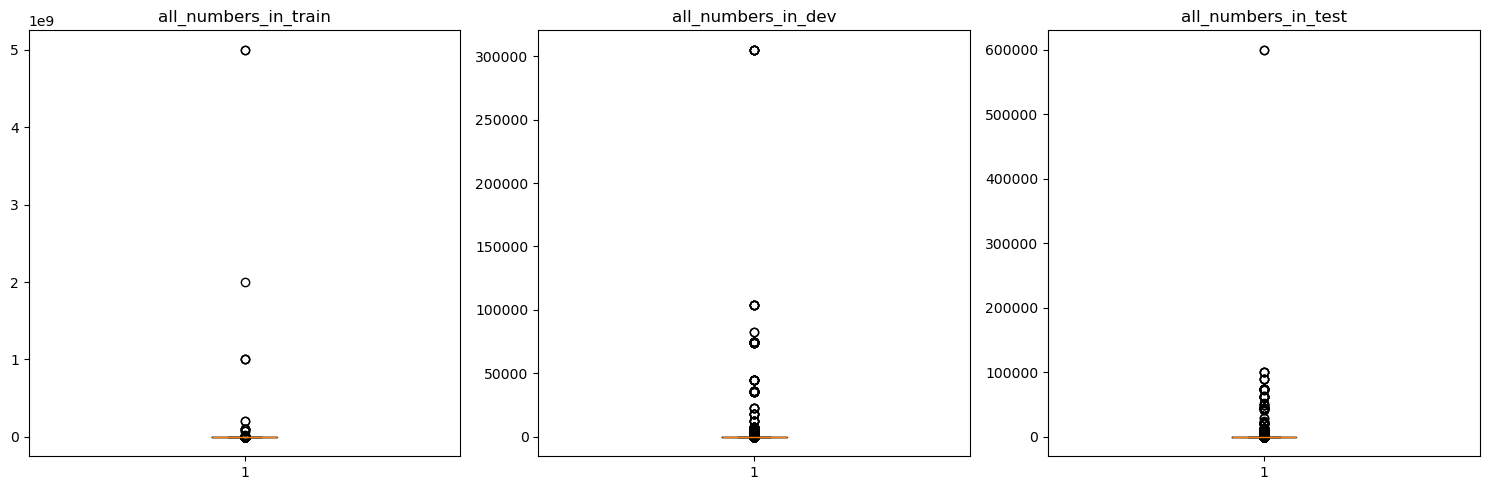

In [31]:
# Create subplots
plt.figure(figsize=(15, 5))  # Adjust the figure size as needed

# Subplot 1
plt.subplot(1, 3, 1)
plt.boxplot(all_numbers_in_train)
plt.title('all_numbers_in_train')

# Subplot 2
plt.subplot(1, 3, 2)
plt.boxplot(all_numbers_in_dev)
plt.title('all_numbers_in_dev')

# Subplot 3
plt.subplot(1, 3, 3)
plt.boxplot(all_numbers_in_test)
plt.title('all_numbers_in_test')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

The magnitude of the number is skewly distributed (much more small numbers than large number outliers), esp in `train`. This info helps us to decide how to transform numbers into embeddings:   
* It's unrealistic to encode numeral tokens as one-hot vector, since the embedding can be too sparse.    




\[that's a dumb idea, don't do that\]  
~~Therefore we encode the original number as decomposition of power of 10, eg. 248 is encoded as [0,0,0,...0,2,4,8], the number of 0 paddings at left is decided by the largest number: the paddings should be large enough to accommodate the largest number. ~~
Largest number has 10 digits, so let the embedding be of dimension 100, 50 of them represent the number before dot, the other 50 represent the fractions. This should be more than enough. 

## Ae numbers all of numerical format? (eg. no “two” for 2

In [32]:
number_string_list = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

In [34]:
def extract_number_strings(sentence):
    return [symbol for symbol in number_string_list if symbol in sentence]

def get_number_strings(dataset):
    return [{
                'index': idx,
                'statement1': extract_number_strings(record['statement1']), 
                'statement2': extract_number_strings(record['statement2'])
            } 
                for idx, record in enumerate(dataset)
                    if len(extract_number_strings(record['statement1'])) > 0 or len(extract_number_strings(record['statement2'])) > 0
                
            ]

In [35]:
get_number_strings(train)

[{'index': 0, 'statement1': ['one'], 'statement2': []},
 {'index': 18, 'statement1': ['one', 'two'], 'statement2': ['one', 'two']},
 {'index': 21, 'statement1': ['one'], 'statement2': []},
 {'index': 26, 'statement1': ['one'], 'statement2': ['one']},
 {'index': 37, 'statement1': ['six'], 'statement2': []},
 {'index': 39, 'statement1': ['two'], 'statement2': []},
 {'index': 41, 'statement1': ['two'], 'statement2': ['two']},
 {'index': 64, 'statement1': ['one', 'three'], 'statement2': ['one', 'three']},
 {'index': 66, 'statement1': ['two', 'three'], 'statement2': ['two', 'three']},
 {'index': 70, 'statement1': ['one'], 'statement2': ['one']},
 {'index': 71, 'statement1': ['three', 'six'], 'statement2': ['three']},
 {'index': 74, 'statement1': ['six'], 'statement2': ['six']},
 {'index': 77, 'statement1': ['one'], 'statement2': []},
 {'index': 78, 'statement1': ['three'], 'statement2': ['three']},
 {'index': 88, 'statement1': ['one'], 'statement2': ['one']},
 {'index': 100, 'statement1': [

In [36]:
train[940]

{'statement1': 'Richard will arrange 6 people of 6 different heights for photograph by placing them in two rows of three so that each person in the first row is standing is standing in front of someone in the second row',
 'statement2': 'Richard will arrange less than 6 people of 6 different heights for photograph by placing them in two rows of three so that each person in the first row is standing is standing in front of someone in the second row',
 'options': ' Entailment or contradiction or neutral?',
 'answer': 'contradiction',
 'type': 'Type_7',
 'statement1_sci_10E': 'Richard will arrange 6.0000000000E+00.0000000000E+00 people of 6.0000000000E+00.0000000000E+00 different heights for photograph by placing them in two rows of three so that each person in the first row is standing is standing in front of someone in the second row',
 'statement1_char': 'Richard will arrange 6 people of 6 different heights for photograph by placing them in two rows of three so that each person in the 

Leave it as it is for now, let's build a very rough model then see error analysis if this is relevant. 

# number of tokens in s1 and s2

In [39]:
ori = ("statement1", "statement2")
sci = ("statement1_sci_10E", "statement2_sci_10E")
ori_char = ("statement1_char", "statement2_char")
sci_char = ("statement1_sci_10E_char", "statement2_sci_10E_char") 

In [42]:
print(len(train))
print(len(dev))
print(len(test))

6475
970
1691


In [53]:
def get_num_tokens(dataset, notation):
    k1 = notation[0]
    k2 = notation[1]
    return np.array([ len((record[k1] + " " + record[k2]).split(" ")) for record in dataset])

In [54]:
train_ori = get_num_tokens(train, ori)
train_sci = get_num_tokens(train, sci)
train_ori_char = get_num_tokens(train, ori_char)
train_sci_char = get_num_tokens(train, sci_char)

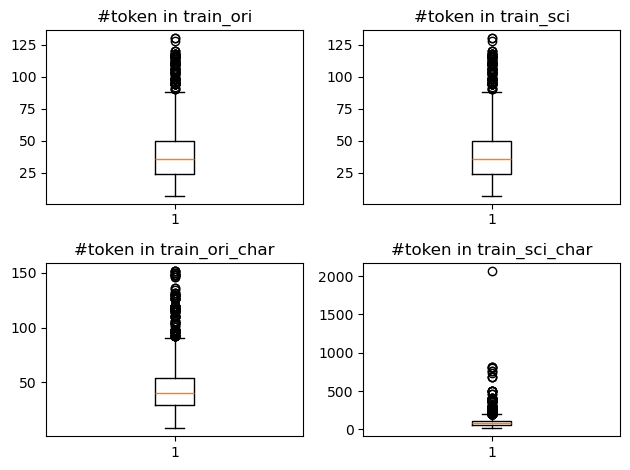

In [55]:

fig, axs = plt.subplots(2, 2)

# Plot boxplots on each subplot
axs[0, 0].boxplot(train_ori)
axs[0, 0].set_title('#token in train_ori')

axs[0, 1].boxplot(train_sci)
axs[0, 1].set_title('#token in train_sci')

axs[1, 0].boxplot(train_ori_char)
axs[1, 0].set_title('#token in train_ori_char')

axs[1, 1].boxplot(train_sci_char)
axs[1, 1].set_title('#token in train_sci_char')

# Adjust layout to prevent overlapping titles
plt.tight_layout()

# Show the plot
plt.show()


While it's as expected that original notation have the same token count as scientific notation, and original_character notation has a bit more number of tokens compared to the original, the number of tokens in scientific_character blows up by a factor of x100. 

## a closer look at sci_char

In [56]:
ori_diff = train_ori_char - train_ori
sci_diff = train_sci_char - train_sci

In [61]:
ori_ratio = train_ori_char / train_ori
sci_ratio = train_sci_char / train_sci

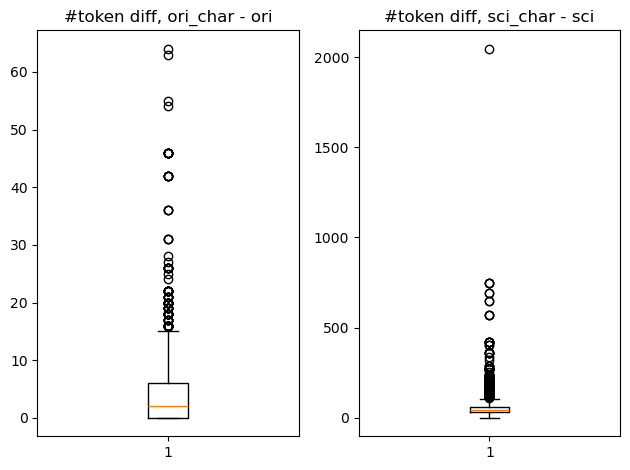

In [65]:
fig, axs = plt.subplots(1, 2)

# Plot boxplots on each subplot
axs[0].boxplot(ori_diff)
axs[0].set_title('#token diff, ori_char - ori')

axs[1].boxplot(sci_diff)
axs[1].set_title('#token diff, sci_char - sci')

plt.tight_layout()

plt.show()

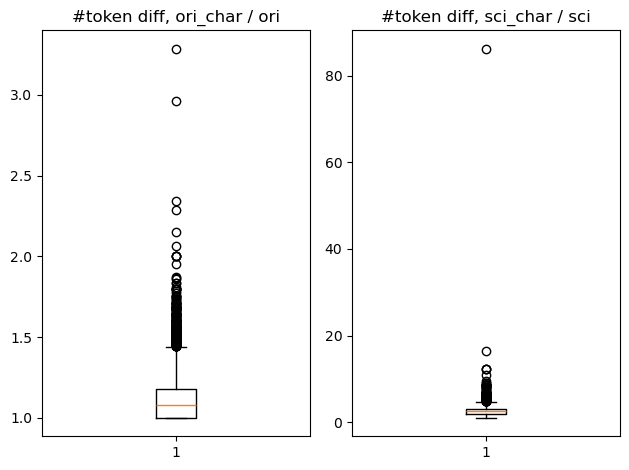

In [66]:
fig, axs = plt.subplots(1, 2)

axs[0].boxplot(ori_ratio)
axs[0].set_title('#token diff, ori_char / ori')

axs[1].boxplot(sci_ratio)
axs[1].set_title('#token diff, sci_char / sci')

plt.tight_layout()

plt.show()

In [60]:
np.sum(sci_diff > 500)

11

In [70]:
indices = np.where(sci_diff > 500)[0]

In [72]:
for ind in indices: 
    pretty_print(train[ind])
    print("======================")

{
    "statement1": "Last year 12 members of the club traveled to both England and France , 6 members traveled to both England and Italy , and 0 members traveled to both France and Italy",
    "statement2": "Last year less than 12 members of the club traveled to both England and France , 6 members traveled to both England and Italy , and 0 members traveled to both France and Italy",
    "options": " Entailment or contradiction or neutral?",
    "answer": "contradiction",
    "type": "Type_7",
    "statement1_sci_10E": "Last year 1.20.0000000000E+000.0000000000E+000.0000000000E+000.0000000000E+000.0000000000E+000.0000000000E+000.0000000000E+000.0000000000E+000.0000000000E+00E+0.0000000000E+001 members of the club traveled to both England and France , 6.0.0000000000E+000.0000000000E+000.0000000000E+000.0000000000E+000.0000000000E+000.0000000000E+000.0000000000E+000.0000000000E+000.0000000000E+000.0000000000E+00E+0.0000000000E+000.0000000000E+00 members traveled to both England and Italy 

Just a brief look we can see the data quality of sci and sci_char are worrysome. 

In [76]:
lt_500 = sci_diff < 500
gt_300 = sci_diff > 300
check = lt_500 & gt_300

In [78]:
indices = np.where(check)[0]
print(len(indices))
indices

15


array([ 332, 1446, 1913, 2785, 2973, 3335, 3582, 3922, 3968, 4960, 5144,
       5165, 5439, 5583, 5841])

In [80]:
for ind in indices: 
    print("========")
    pretty_print(train[ind])

{
    "statement1": "Series Problem like more than 2 12 x 44 46 132 134 begin of the Skype highlighting 44 46 132 134 end of the Skype highlighting",
    "statement2": "Series Problem like 4 12 x 44 46 132 134 begin of the Skype highlighting 44 46 132 134 end of the Skype highlighting",
    "options": " Entailment or contradiction or neutral?",
    "answer": "neutral",
    "type": "Type_7",
    "statement1_sci_10E": "Series Problem like more than 2.0000000000E+00 1.2000000000E+01.0000000000E+00 x 4.4000000000E+01 4.6000000000E+01 1.3200000000E+02.0000000000E+00 1.3400000000E+02 begin of the Skype highlighting 4.4000000000E+01 4.6000000000E+01 1.3200000000E+02.0000000000E+00 1.3400000000E+02 end of the Skype highlighting",
    "statement1_char": "Series Problem like more than 2 1 2 x 4 4 4 6 1 3 2 1 3 4 begin of the Skype highlighting 4 4 4 6 1 3 2 1 3 4 end of the Skype highlighting",
    "statement1_sci_10E_char": "Series Problem like more than 2 . 0 0 0 0 0 0 0 0 0 0 E + 0 0 1 . 2 0 

Same problem as above, scientific notation and scientific_character notation is messed up.  

Since we have limited time, we will forego the discussion of scientific notation and scientific_character notation.

# end